# Dependencies

In [1]:
!pip install augmentations

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.6 MB/s eta 0:00:00
  Created wheel for turfpy: filename=turfpy-0.0.7-py3-none-any.whl size=39098 sha256=f7d08f635b6590c8e7f6895142d3345debd7619684212e2d7e540ed387ea7f3f
  Stored in directory: /root/.cache/pip/wheels/7a/05/e3/11a72686a770c2117b4465d02abd5f25f8d94c2f823ca0c112
Successfully built turfpy


In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

## Testing Utils

In [3]:
def test_double_convolution(input_shape):
    test_model = DoubleConvolution(input_channels=1, output_channels=64)
    array = torch.rand(* input_shape)
    
    output = test_model(array)
    
    print(output.shape)

In [4]:
def unet_test():
    x = torch.randn((3, 1, 160, 160)) #chose height and width divisble by 16
    model = Unet(input_channels=1, output_channels=1)
    preds = model(x)
    assert preds.shape == x.shape 
    

## Utils Function

In [5]:
def compute_parameters():
    model = Unet(input_channels=1, output_channels=1)
    total_params = 0
    for param in model.parameters():
        total_params += sum([param.numel()])
        
    return total_params

In [6]:
def show_images_side_by_side(image1, image2, cmap='gray'):
    plt.figure(figsize=(10, 5))

    # Display the first image
    plt.subplot(1, 2, 1)
    plt.imshow(image1, cmap=cmap)
    plt.axis('off')  # Hide axes

    # Display the second image
    plt.subplot(1, 2, 2)
    plt.imshow(image2, cmap=cmap)
    plt.axis('off')  # Hide axes

    # Show the images
    plt.show()

In [7]:
def save_checkpoint(state, epoch):
    print("=> Saving checkpoint")
    torch.save(state, f'/kaggle/working/model_{epoch}.pth')

## Unet Model

In [8]:
class DoubleConvolution(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(DoubleConvolution, self).__init__()
        
        self.convolutions = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        return self.convolutions(x)


In [9]:
test_double_convolution(input_shape=(1, 1, 32, 32))

torch.Size([1, 64, 32, 32])


In [10]:
class Unet(nn.Module):
    def __init__(self, input_channels, output_channels, transform=None, split='train', features=[64, 128, 256, 512], distinct_pixel_values = 1):
        super(Unet, self).__init__()
        
        self.up_sampling = nn.ModuleList()
        self.down_sampling = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        for feature in features:
            self.down_sampling.append(DoubleConvolution(input_channels, feature))
            input_channels = feature
        
        for feature in features[::-1]:
            self.up_sampling.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.up_sampling.append(DoubleConvolution(feature*2, feature))
            
        self.bottleneck = DoubleConvolution(features[-1], features[-1] * 2)
        self.final_layer = nn.Conv2d(features[0], output_channels * distinct_pixel_values, kernel_size=1)
        
    def forward(self, x):
        skip_connections = []

        for down in self.down_sampling:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for i in range(0, len(self.up_sampling), 2):
            x = self.up_sampling[i](x) #applying double conv
            skip_volume = skip_connections[i//2]

            concatenated = torch.cat((x, skip_volume), dim=1)

            x = self.up_sampling[i+1](concatenated)

        return self.final_layer(x)
                

In [11]:
unet_test()

In [12]:
compute_parameters()

31036481

## Dataset

In [13]:
TRAIN_IMAGE_DIR = '/kaggle/input/camvid/CamVid/train'
TRAIN_LABEL_DIR = '/kaggle/input/camvid/CamVid/train_labels'

TEST_IMAGE_DIR = '/kaggle/input/camvid/CamVid/test'
TEST_LABEL_DIR = '/kaggle/input/camvid/CamVid/test_labels'

VAL_IMAGE_DIR = '/kaggle/input/camvid/CamVid/val'
VAL_LABEL_DIR = '/kaggle/input/camvid/CamVid/val_labels'

RESIZE_HEIGHT = 512
RESIZE_WIDTH = 512


### Observing Data

In [14]:
from PIL import Image
import os

image_name = os.listdir(TRAIN_IMAGE_DIR)[-23]

image = Image.open(os.path.join(TRAIN_IMAGE_DIR, image_name))
npy_image = np.array(image)
npy_image.shape

(720, 960, 3)

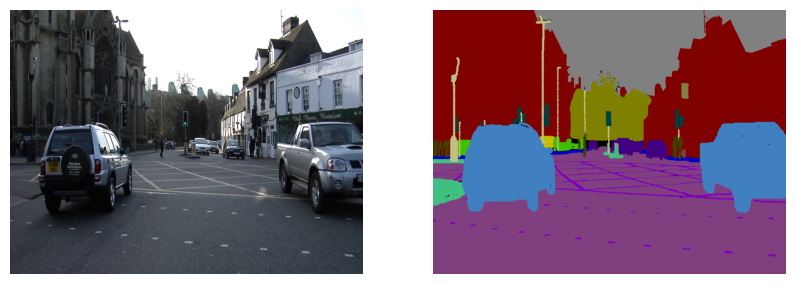

In [15]:
mask_image = Image.open(os.path.join(TRAIN_LABEL_DIR, image_name.replace('.png','_L.png')))

show_images_side_by_side(image, mask_image)

In [16]:
np.array(mask_image.convert('RGB')).shape, np.array(image.convert("RGB")).shape

((720, 960, 3), (720, 960, 3))

In [17]:
pixel_values = np.array(mask_image).flatten().tolist()
unique_class = set(pixel_values)
print(unique_class)
#so basically there are 4 pixel possible values for the mask_image
class_map = {
    0: 0,
    1: 64,
    2: 128,
    3: 192
}


{128, 0, 64, 192}


In [18]:
print('Training Examples: ',len(os.listdir(VAL_IMAGE_DIR)))

Training Examples:  100


### Custom Dataset

In [19]:
class CustomDataset(nn.Module):
    def __init__(self, image_dir, mask_dir, transform=None, split='train', val_dir=None):
        super(CustomDataset, self).__init__()
        
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.classes = [128, 0, 64, 192]
        self.images = os.listdir(image_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace('.png', '_L.png'))
        
        image = np.array(Image.open(image_path).convert('RGB'), dtype=np.float32)
        mask = np.array(Image.open(mask_path).convert('RGB'), dtype=np.float32)
        
        mask[mask == 64.0] = 1.0
        mask[mask == 128.0] = 2.0
        mask[mask == 192.0] = 3.0
        
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            
            
            image = augmentations['image']
            mask = augmentations['mask']
        
        if mask.shape[-1] == 3 or mask.shape[-1] == 12:
            mask = mask.permute( 2, 0, 1)
        
        return image, mask.to(torch.int64)
        
            

### Defining Transformation to normalize and resize the image

In [20]:
train_transform = A.Compose(
        [
            A.Resize(height=RESIZE_HEIGHT, width=RESIZE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

## Hyperparameters

In [21]:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 2
NUM_EPOCHS = 200
NUM_WORKERS = 2
# IMAGE_HEIGHT = 160  # 1280 originally
# IMAGE_WIDTH = 240  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = True

In [22]:
print(DEVICE)

cuda


In [23]:
train_dataset = CustomDataset(TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR, train_transform)

In [24]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

## Training Loop

In [141]:
from tqdm.auto import tqdm

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.to(device=DEVICE) #converting height, width --> channels, height, width as gray scale mask has only 1 channel so it doesnt add the channel dimesnion by default
        # forward
        with torch.cuda.amp.autocast():
            #prediciotn --> (batch_size, channel * class, height, width)
            # 0->3 red patch 4->7 green 8->11 bluepatch each channel pixel has 4 vals
            predictions = model(data)
            red_pred = predictions[:,:4,:,:]
            green_pred = predictions[:,4:8,:,:]
            blue_pred = predictions[:,8:,:,:]
            
            #actual image dimensions --> (batch_size, channels, height, width)
            actual_red = targets[:,0,:,:]
            actual_green = targets[:,1,:,:]
            actual_blue = targets[:,2,:,:]
            
            red_loss = loss_fn(red_pred, actual_red)
            green_loss = loss_fn(green_pred, actual_green)
            blue_loss = loss_fn(blue_pred, actual_blue)
            loss = (red_loss + green_loss + blue_loss)/3
            
            assert red_pred.shape == green_pred.shape
            assert red_pred.shape == blue_pred.shape
            
            if loss.item() < 0:
                print('-ve loss detected')

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward() 
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


In [142]:
model = Unet(input_channels=3, output_channels=3, distinct_pixel_values=4).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#scaler helps when working with mixed precision and avoid issues like overflow or underflow when working with 16-bit
scaler = torch.cuda.amp.GradScaler()

In [143]:
saved_epochs = 119

if LOAD_MODEL:
    print('loading checkpoint:',saved_epochs)
    checkpoint = torch.load(f'model_{saved_epochs}.pth')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

loading checkpoint: 119


In [ ]:
for epoch in range(saved_epochs + 1, saved_epochs + 1 + NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)
        
        if (epoch + 1) % 20 == 0:
            # save model
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer":optimizer.state_dict(),
            }
            save_checkpoint(checkpoint, epoch)

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

In [48]:
image_name = os.listdir(TEST_IMAGE_DIR)[-87]

image = Image.open(os.path.join(TEST_IMAGE_DIR, image_name))
label_image = Image.open(os.path.join(TEST_LABEL_DIR, image_name.replace('.png','_L.png')))
npy_image = np.array(image)
npy_image.shape

(720, 960, 3)

In [49]:
inference_transform = A.Compose(
        [
            A.Resize(height=RESIZE_HEIGHT, width=RESIZE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

In [29]:
checkpoint = torch.load('/kaggle/working/model_299.pth')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [50]:
def perform_inference(npy_image, model, DEVICE, val_transform):
    augmentation = val_transform(image = npy_image)
    image = augmentation['image']
#     image = torch.tensor(npy_image.transpose((2, 1, 0)), dtype=torch.float32)
    print(image.shape)

    with torch.no_grad():
        prediction = model(image.unsqueeze(0).to(DEVICE))[0]
        print(prediction.shape)
        red_patch = prediction[:4,:,:]
        green_patch = prediction[4:8,:,:]
        blue_patch = prediction[8:, : ,:]
        
        assert red_patch.shape == green_patch.shape
        assert red_patch.shape == blue_patch.shape
        
        red_probs = torch.softmax(red_patch, dim=0)
        green_probs = torch.softmax(green_patch, dim=0)
        blue_probs = torch.softmax(blue_patch, dim=0)
        
        red_pred_patch = torch.argmax(red_probs, dim=0)
        green_pred_patch = torch.argmax(green_probs, dim=0)
        blue_pred_patch = torch.argmax(blue_probs, dim=0)
        
        final_pred_image = torch.stack([red_pred_patch, green_pred_patch, blue_pred_patch], dim=0)
        
        
        numpy_image = final_pred_image.cpu().numpy()
        
        for key in class_map.keys():
            numpy_image[numpy_image == key] = class_map[key]
            
        return numpy_image
        
        # Convert to binary tensor (0 or 1)
#         image_tensor = (prediction > 0.5).cpu().float()
        
#         # Squeeze to remove dimensions of size 1
#         image_numpy_array = binary_tensor.squeeze().numpy()
        
#         #Replac values greater than 0.5 with 255.0 white value
#         binary_tensor[binary_tensor > 0.5] = 255.0
        
#     return Image.fromarray(binary_tensor)
        
numpy_image = perform_inference(npy_image, model, DEVICE, inference_transform)
print(numpy_image.shape, numpy_image.dtype)


torch.Size([3, 512, 512])
torch.Size([12, 512, 512])
(3, 512, 512) int64


In [51]:
numpy_image = numpy_image.transpose(1, 2,  0)
numpy_image.shape

(512, 512, 3)

In [52]:
pil_image = Image.fromarray(numpy_image.astype(np.uint8))

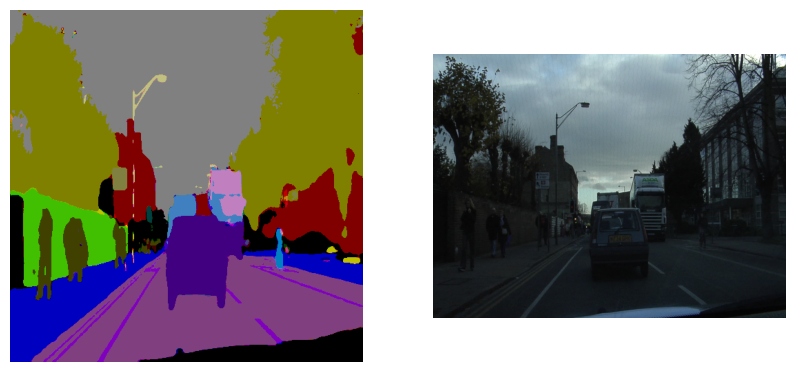

In [53]:
show_images_side_by_side(pil_image, image)

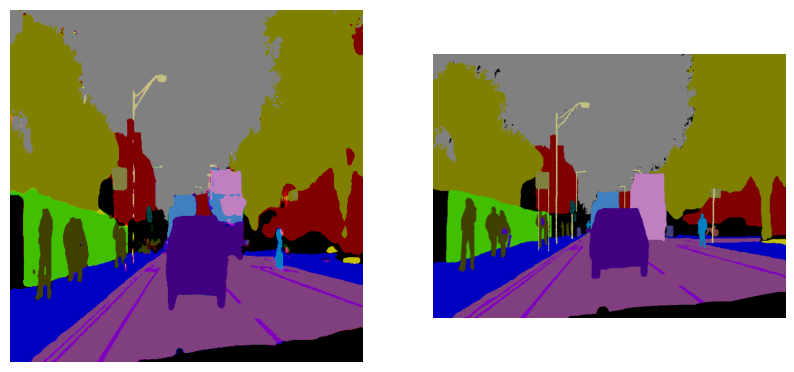

In [54]:
show_images_side_by_side(pil_image, label_image)